In [1]:
import pyspark.sql.functions as F
import datetime as dt
import pandas as pd
import pyspark.sql.types as st
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style("whitegrid")
sc.setLogLevel("INFO")
udf = F.udf
%matplotlib inline

/mnt/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [113]:
PERIODS = {}
N_WEEKS = 6
for i in range(1, N_WEEKS + 1):
    PERIODS[i] = {
        'start': i * 7,
        'end': i * 7 + 6
    }


def date_plus_x_days(date, x):
    """
    Returns a string date x days away from <date>
    
    Params:
    date (str): date in %Y%m%s format
    x (int) number of days to add to <date> (can be negative)
    
    >>> date_plus_x_days("20180101", 1)
    "20180102"
    
    >>> date_plus_x_days("20180510", -9)
    "20180501"
    """
    new_date = dt.datetime.strptime(date, '%Y%m%d') + dt.timedelta(days=x)
    return new_date.strftime('%Y%m%d')


def date_diff(d1, d2, fmt='%Y%m%d'):
    """
    Returns days elapsed from d2 to d1 as an integer

    Params:
    d1 (str)
    d2 (str)
    fmt (str): format of d1 and d2 (must be the same)

    >>> date_diff('20170205', '20170201')
    4

    >>> date_diff('20170201', '20170205)
    -4
    """
    try:
        return (pd.to_datetime(d1, format=fmt) - 
                pd.to_datetime(d2, format=fmt)).days
    except:
        return None


@udf(returnType=st.IntegerType())
def get_period(anchor, submission_date_s3):
    """
    Given an anchor and a submission_date_s3,
    returns what period a ping belongs to. This 
    is a spark UDF (see decoration).

    Params:
    anchor (col): anchor date
    submission_date_s3 (col): a ping's submission_date to s3

    Global:
    PERIODS (dict): defined globally based on n-week method

    Returns an integer indicating the retention period
    """
    if anchor is not None:
        diff = date_diff(submission_date_s3, anchor)
        if diff >= 7: # exclude first 7 days
            for period in sorted(PERIODS):
                if diff <= PERIODS[period]['end']:
                    return period
                
def get_retention(data):
    branch_counts = (
        data
        .groupby("branch")
        .agg(F.countDistinct("client_id").alias("total_clients"))
        )

    weekly_counts = (
        data
        .groupby("period", "branch")
        .agg(F.countDistinct("client_id").alias("n_week_clients"))
    )

    retention_by_branch = (
        weekly_counts
        .join(branch_counts, on='branch')
        .withColumn("retention", F.col("n_week_clients") / F.col("total_clients"))
    )
    
    ret_df = retention_by_branch.toPandas()
    ret_df.fillna(0, inplace=True)
    
    return ret_df

### Data Prep

Load in cleaned experiment data, generated from [this notebook](https://github.com/mozilla/taar/blob/master/analysis/TAARExperimentV2Analysis.ipynb).

In [3]:
S3_PATH = "s3://net-mozaws-prod-us-west-2-pipeline-analysis/taarv2/cleaned_data/"
clean_data = sqlContext.read.parquet(S3_PATH)
clean_data.count()

4273584

Grab the min and max submission dates for filtering `main_summary`.

In [4]:
min_date = clean_data.select(F.min('submission_date_s3').alias('min_d')).collect()[0].min_d
max_date = clean_data.select(F.max('submission_date_s3').alias('max_d')).collect()[0].max_d
print min_date, max_date

20180312 20180423


Load in `main_summary`, filtered to the min date of the experiment, and 42 days beyond its compleition to allow for 6-week Retention Analysis. We then join `main_summary` with the experiment data.

In [5]:
ms = (
    sqlContext.read.option("mergeSchema", True)
     .parquet("s3://telemetry-parquet/main_summary/v4")
     .filter("submission_date_s3 >= '{}'".format(min_date))
     .filter("submission_date_s3 <= '{}'".format(date_plus_x_days(max_date, 7*6)))
     .filter("normalized_channel = 'release'")
     .filter("app_name = 'Firefox'")
)

In [6]:
# a client's enrollment date is determined by their first appearance in the experiment
enrollment_dates = (
    clean_data.groupby("client_id", "branch")
     .agg(F.min('submission_date_s3')
          .alias("enrollment_date"))
)

In [7]:
# join main_summary to exp data
joined = enrollment_dates.join(ms.select("submission_date_s3", "client_id"), on="client_id", how='left')

In [8]:
# verify join contains same number of distinct clients as the experiment data.
# this also initializes our cache
jc = joined.select("client_id").distinct().count()
cc = clean_data.select("client_id").distinct().count()

In [9]:
jc - cc

0

### Calculate Retention Data

Perform 6-week retention analysis based on [this example](https://docs.telemetry.mozilla.org/cookbooks/retention.html). [1-5]-Week Retention are additionally included since we can get them at a low cost.

In [10]:
joined = (
    joined.withColumn("period", get_period("enrollment_date", "submission_date_s3"))
          .filter("enrollment_date <= '{}'".format(max_date))
).distinct().cache()

In [11]:
joined.count()

43190456

In [114]:
ret_df  = get_retention(joined)

In [115]:
#ret_df.to_csv("taar_v2_retention.csv", index=False)

Write to s3 since this job is quite expensive and should only be run once.

In [116]:
#%%bash
#aws s3 cp taar_v2_retention.csv s3://net-mozaws-prod-us-west-2-pipeline-analysis/taarv2/

### Load processed Retention Data

This section loads the data generated above without having to the re-run the entire notebook.

In [117]:
#%%bash 
#aws s3 cp s3://net-mozaws-prod-us-west-2-pipeline-analysis/taarv2/taar_v2_retention.csv .

In [118]:
#ret_df = pd.read_csv("taar_v2_retention.csv")

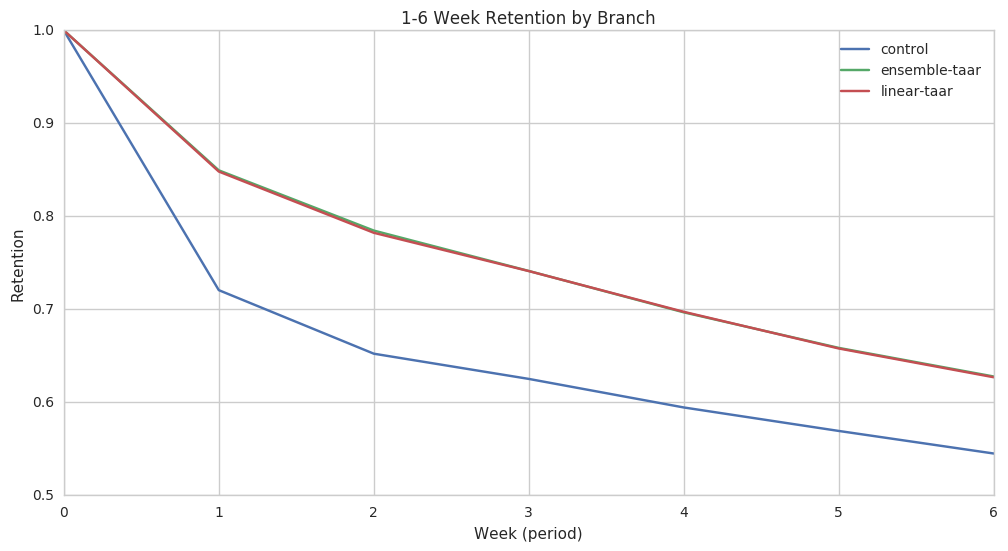

In [119]:
plt.rcParams['figure.figsize'] = (12, 6)
fig, ax = plt.subplots()
for group, data in ret_df.groupby("branch"):
    (data.sort_values("period")
         .plot(x='period', 
               y='retention', 
               ax=ax, 
               label=group))
plt.ylabel("Retention")
plt.xlabel("Week (period)")
plt.title("1-6 Week Retention by Branch")
plt.show()

In [120]:
ret_df[ret_df.period == 6.0].sort_values("retention", ascending=False)

,branch,period,n_week_clients,total_clients,retention
6,ensemble-taar,6.0,77880,124057,0.627776
18,linear-taar,6.0,77576,123735,0.626953
10,control,6.0,620751,1139076,0.544960


# Investigate nearly identical retention lines for TAAR Branches

Let's look at 6-week retention over time by each enrollment date

In [121]:
day_over_day_retention = []
for i in range(40):
    d = date_plus_x_days("20180312", i)
    joinedx = joined.filter("enrollment_date = '{}'".format(d))
    ret_dfx = get_retention(joinedx)
    week6 = ret_dfx[ret_dfx.period == 6.0]
    for b, data in week6.groupby("branch"):
        x = {
            'branch': b,
            'ret': data['retention'].values[0],
            'date': d
        }
        day_over_day_retention.append(x)

/mnt/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


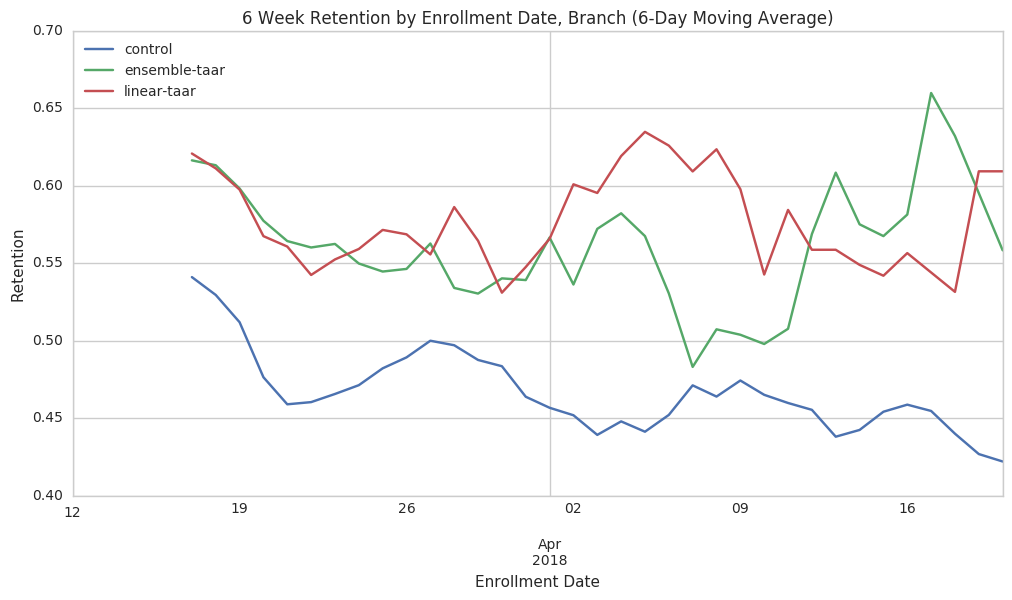

In [133]:
day_over_day_retention_df = pd.DataFrame(day_over_day_retention)
day_over_day_retention_df.date = (
    pd.to_datetime(day_over_day_retention_df.date, format='%Y%m%d'))

plt.rcParams['figure.figsize'] = (12, 6)
fig, ax = plt.subplots()
for group, data in day_over_day_retention_df.groupby("branch"):
    data['ma'] = data.ret.rolling(window=6).mean()
    (data.sort_values("date")
         .plot(x='date', 
               y='ma', 
               ax=ax, 
               label=group))
plt.ylabel("Retention")
plt.xlabel("Enrollment Date")
plt.title("6 Week Retention by Enrollment Date, Branch (6-Day Moving Average)")
plt.show()

day_over_day_retention_df.ret.rolling(window=6).mean()

Let's now look at retention by enrollment week

In [123]:
# add week of year column
joined = joined.withColumn("week", F.weekofyear(F.concat(
    F.substring("enrollment_date", 0, 4),
    F.lit('-'),
    F.substring("enrollment_date", 5, 2),
    F.lit('-'),
    F.substring("enrollment_date", 7, 2))))

week_over_week_retention = []
for i in range(6):
    w = 11 + i
    joinedx = joined.filter("week = {}".format(w))
    ret_dfx = get_retention(joinedx)
    week6 = ret_dfx[ret_dfx.period == 6.0]
    for b, data in week6.groupby("branch"):
        x = {
            'branch': b,
            'ret': data['retention'].values[0],
            'week': w
        }
        week_over_week_retention.append(x)

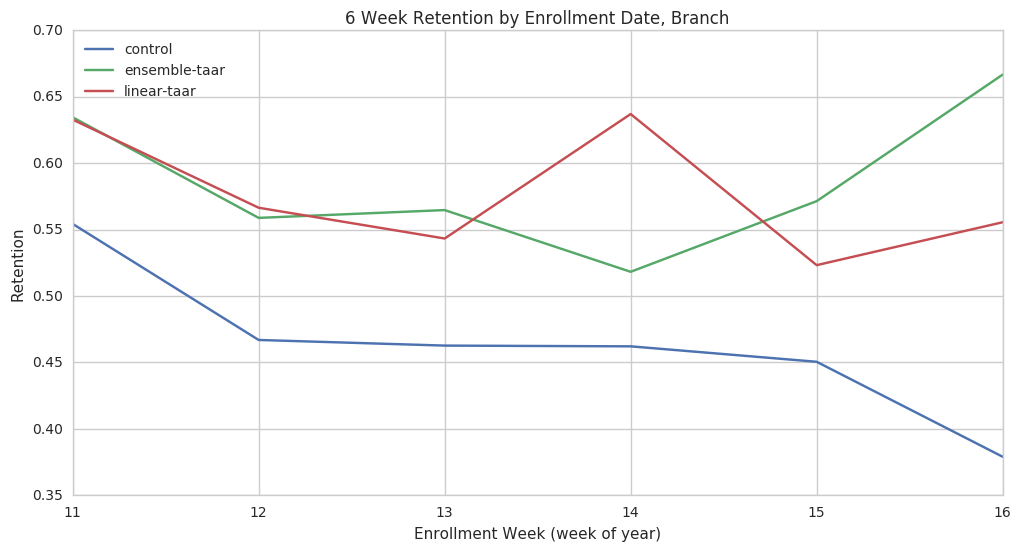

In [128]:
week_over_week_retention_df = pd.DataFrame(week_over_week_retention)

plt.rcParams['figure.figsize'] = (12, 6)
fig, ax = plt.subplots()
for group, data in week_over_week_retention_df.groupby("branch"):
    (data.sort_values("week")
         .plot(x='week', 
               y='ret', 
               ax=ax, 
               label=group))
plt.ylabel("Retention")
plt.xlabel("Enrollment Week (week of year)")
plt.title("6 Week Retention by Enrollment Date, Branch")
plt.show()

Let's go back to 1-6 week retention for different enrollment periods:

* enrollment period of March
* enrollment period of April 1st (a single day)

In [142]:
march_ret = get_retention(joined.filter("enrollment_date < '20180401'"))

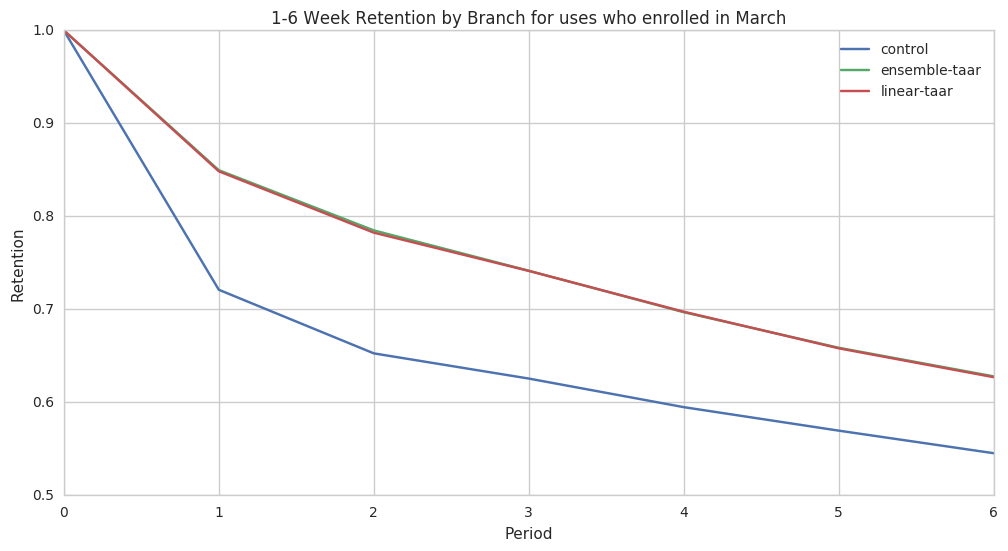

In [145]:
plt.rcParams['figure.figsize'] = (12, 6)
fig, ax = plt.subplots()
for group, data in march_ret.groupby("branch"):
    (data.sort_values("period")
         .plot(x='period', 
               y='retention', 
               ax=ax, 
               label=group))
plt.ylabel("Retention")
plt.xlabel("Period")
plt.title("1-6 Week Retention by Branch for uses who enrolled in March")
plt.show()

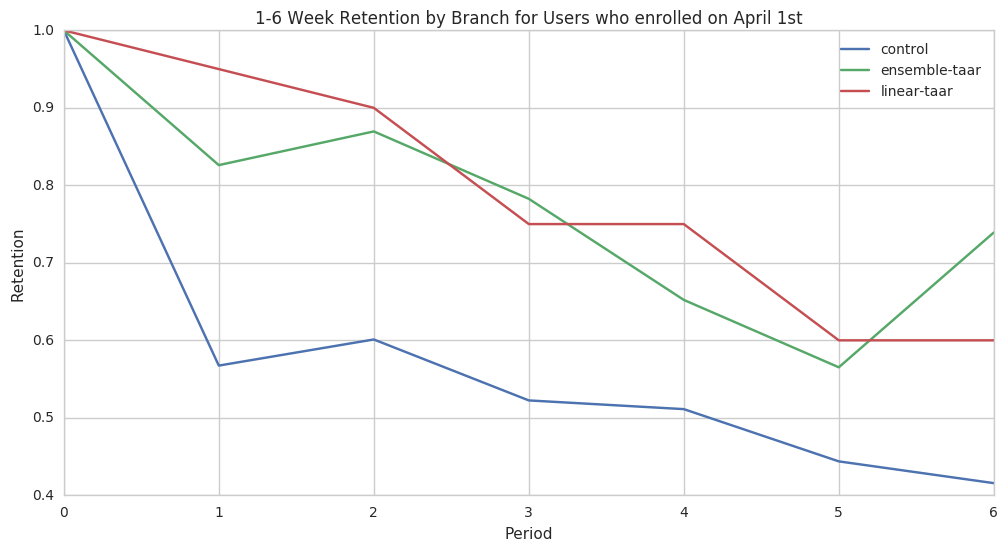

In [146]:
one_day = get_retention(joined.filter("enrollment_date = '20180401'"))

plt.rcParams['figure.figsize'] = (12, 6)
fig, ax = plt.subplots()
for group, data in one_day.groupby("branch"):
    (data.sort_values("period")
         .plot(x='period', 
               y='retention', 
               ax=ax, 
               label=group))
plt.ylabel("Retention")
plt.xlabel("Period")
plt.title("1-6 Week Retention by Branch for Users who enrolled on April 1st")
plt.show()

Breaking retention down into shorter segments shows that there are indeed differences between the taar branches, however they track each other rather closely and are consistently higher than the control. This is evidence that the similarities we see in the lines for the first plot are in fact the true retention values and not a data-handling issue.